In [1]:
# data analysis
import numpy as np
import pandas as pd
import sys
import glob
import os,time

from imp import reload
import coronadataclass as cdc; reload(cdc)

# plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [15,12]


In [7]:
jhudata = cdc.CoronaData(download_data = True)




def LMSQ(x,y):
    n   = len(x)
    sx  = np.sum(x)
    sy  = np.sum(y)
    sxx = np.dot(x,x)
    sxy = np.dot(x,y)
    syy = np.dot(y,y)
    
    denom  = (n*sxx - sx*sx) * 1.
    b      = (n*sxy - sx*sy)/denom
    a      = (sy - b*sx)/n
    estim  = np.array([a,b], dtype = np.float)

    sigma2 = syy + n*a*a + b*b*sxx + 2*a*b*sx - 2*a*sy - 2*b*sxy
    cov    = sigma2 / denom * np.array([[sxx,-sx],[-sx,n]], dtype = np.float)

    return estim,cov



colornames       = [cn for cn in matplotlib.colors.TABLEAU_COLORS.keys() if (cn.upper() != 'TAB:WHITE' and cn.upper() != 'TAB:GRAY')]




-0.011367163253640384 1.408341086590453


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


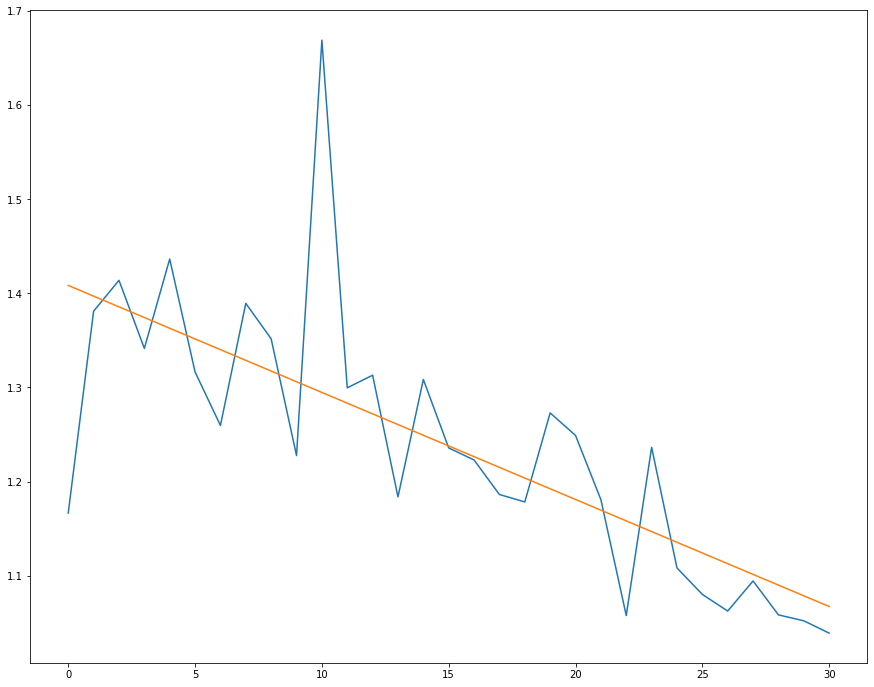

In [8]:
ca = np.array(jhudata.Austria['Confirmed'])

increaserate = (ca[1:]/ca[:-1])[40:]

x = np.arange(len(increaserate))

(b,a), cov = LMSQ(x,increaserate)

print(a,b)


plt.plot(increaserate)
plt.plot(x,a*x+b)
plt.show()

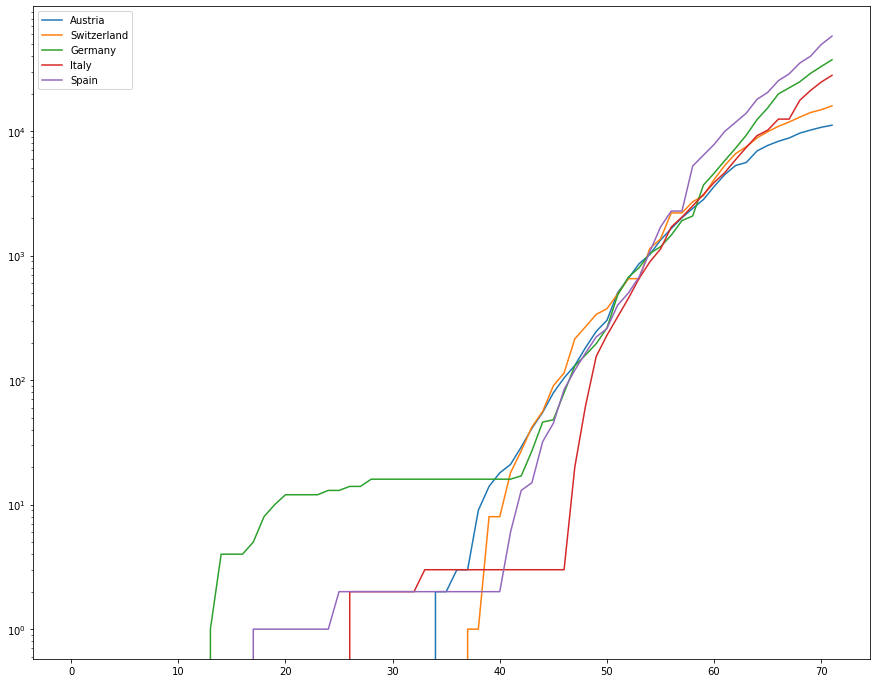

In [9]:
plt.plot(jhudata.Austria    ['Confirmed'],           label = 'Austria')
plt.plot(jhudata.Switzerland['Confirmed'].shift( 3), label = 'Switzerland')
plt.plot(jhudata.Germany    ['Confirmed'].shift( 8), label = 'Germany')
plt.plot(jhudata.Italy      ['Confirmed'].shift(17), label = 'Italy')
plt.plot(jhudata.Spain      ['Confirmed'].shift( 7), label = 'Spain')
plt.legend()
plt.yscale('log')
plt.show()

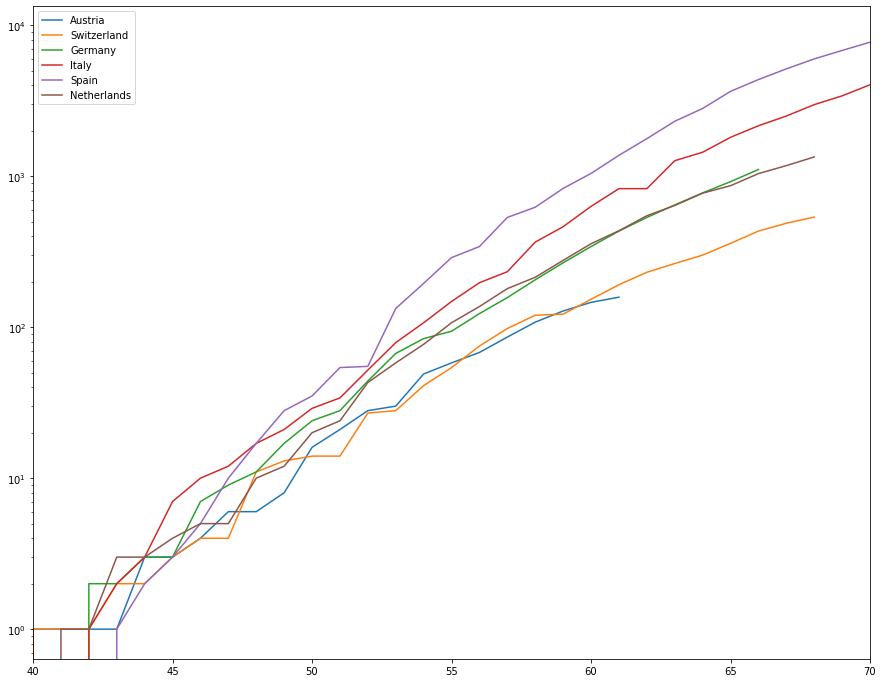

In [10]:
plt.plot(jhudata.Austria    ['Deaths'].shift(-10), label = 'Austria')
plt.plot(jhudata.Switzerland['Deaths'].shift(- 3), label = 'Switzerland')
plt.plot(jhudata.Germany    ['Deaths'].shift(- 5), label = 'Germany')
plt.plot(jhudata.Italy      ['Deaths'].shift( 12), label = 'Italy')
plt.plot(jhudata.Spain      ['Deaths'].shift(  2), label = 'Spain')
plt.plot(jhudata.Netherlands['Deaths'].shift(- 3), label = 'Netherlands')
plt.legend()
plt.yscale('log')
plt.xlim([40,70])
plt.show()

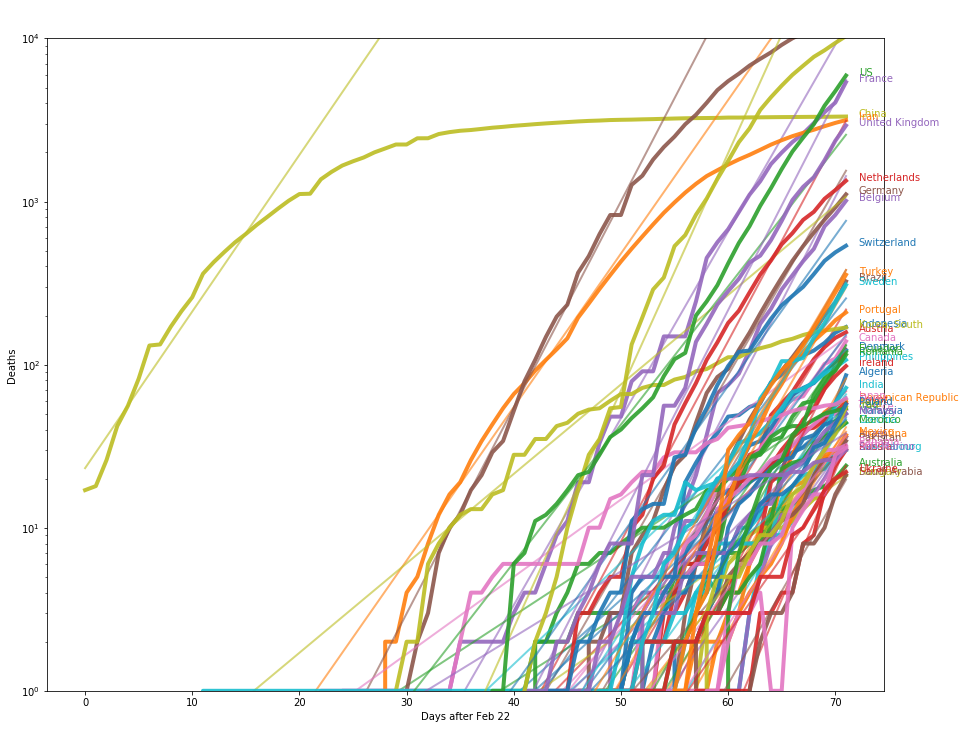

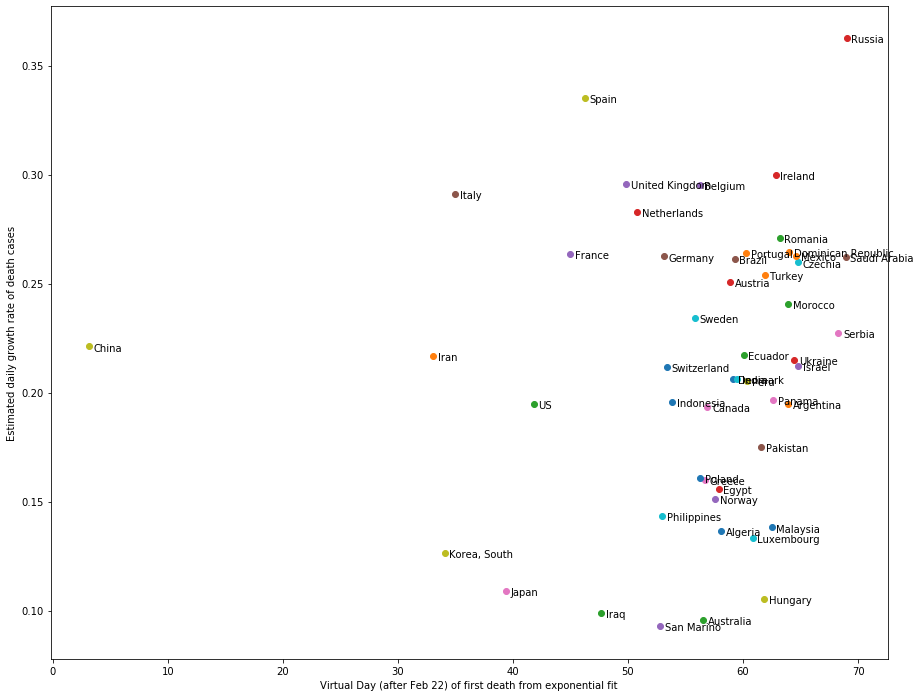

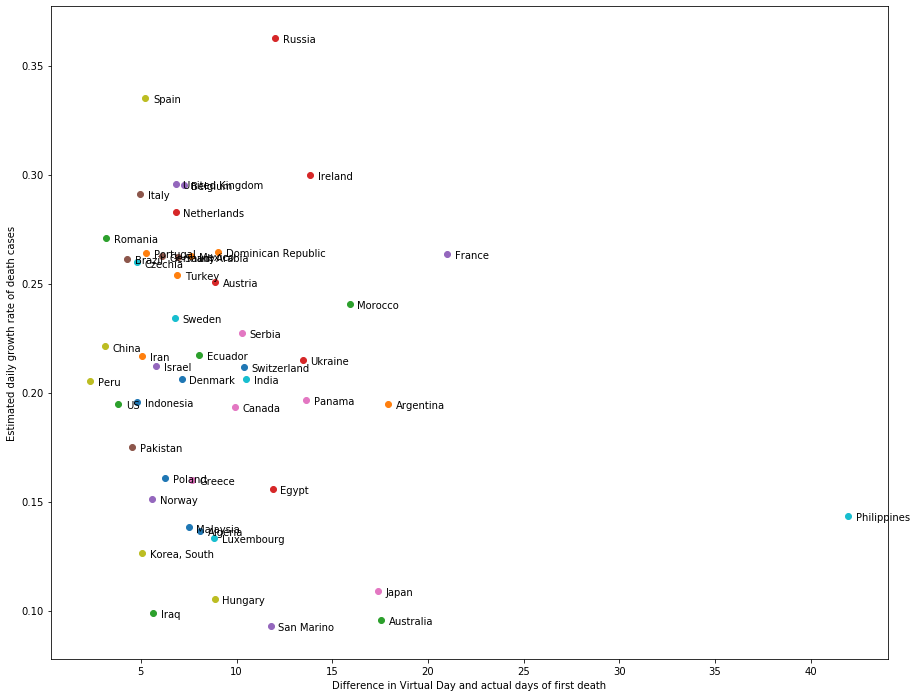

In [11]:
# fit exponential growth of cumulative deaths
# start at 'dthr_fit' cases and continue for 'maxdays' days
# only consider countries with more culumative deaths than 'dthr'

dthr      = 20
dthr_fit  = 5
maxdays   = 20

fig1,ax1  = plt.subplots()
fig2,ax2  = plt.subplots()
fig3,ax3  = plt.subplots()
i         = 0

for country, countrydata in jhudata:
    d = np.array(countrydata['Deaths'])
    if d[-1] >= dthr:
        firstcase = np.min(np.where(d >= 1))
        startfit  = np.min(np.where(d >= dthr_fit))

        x = np.arange(len(d[startfit:min(len(d),startfit+maxdays)]))
        y = np.log(d[startfit:min(len(d),startfit+maxdays)])
        
        if len(y) > 1:
            estim, cov = LMSQ(x,y)
            
            offset2     = np.array([startfit + .4, -.002])
            ax2.scatter(estim[0] + startfit, estim[1],label = country, c = colornames[i % len(colornames)])
            ax2.annotate(country,estim + offset2)

            xx = np.arange(len(data))
            ax1.plot(xx,d, c = colornames[i % len(colornames)], lw = 4, alpha = .9)
            ax1.plot(xx,np.exp(estim[0] + estim[1] * (xx-startfit)), c = colornames[i % len(colornames)], lw = 2, alpha = .6)
            ax1.annotate(country, np.array([len(data)+.2,d[-1]]), c = colornames[i%len(colornames)])
            
            offset3     = np.array([startfit + .4 - firstcase, -.002])
            ax3.scatter(estim[0] + startfit - firstcase, estim[1], label = country, c = colornames[i % len(colornames)])
            ax3.annotate(country,estim + offset3)
            
            i += 1
            
ax1.set_xlabel(r'Days after Feb 22')
ax1.set_ylabel(r'Deaths')
ax1.set_yscale('log')        
ax1.set_ylim([1e0,1e4])
ax2.set_ylabel(r'Estimated daily growth rate of death cases')
ax2.set_xlabel(r'Virtual Day (after Feb 22) of first death from exponential fit')
ax3.set_ylabel(r'Estimated daily growth rate of death cases')
ax3.set_xlabel(r'Difference in Virtual Day and actual days of first death')
plt.show()


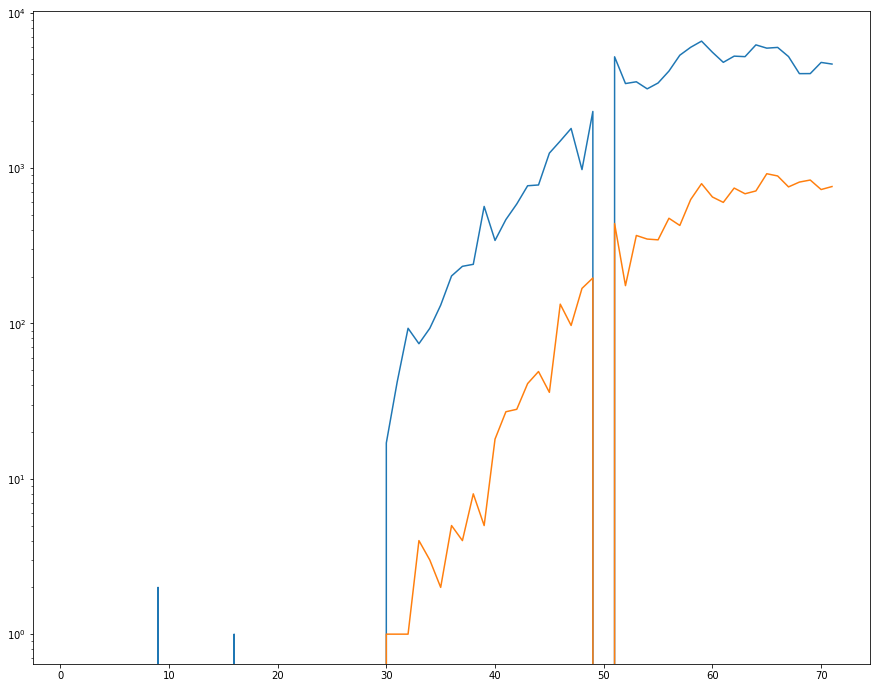

In [12]:
plt.plot(jhudata.Italy['Confirmed']-jhudata.Italy['Confirmed'].shift())
plt.plot(jhudata.Italy['Deaths']-jhudata.Italy['Deaths'].shift())
plt.yscale('log')

Austria Germany
Austria Italy
Austria France
Austria Spain
Austria Netherlands
Austria Belgium
Austria US
Germany Italy
Germany France
Germany Spain
Germany Netherlands
Germany Belgium
Germany US
Italy France
Italy Spain
Italy Netherlands
Italy Belgium
Italy US
France Spain
France Netherlands
France Belgium
France US
Spain Netherlands
Spain Belgium
Spain US
Netherlands Belgium
Netherlands US
Belgium US


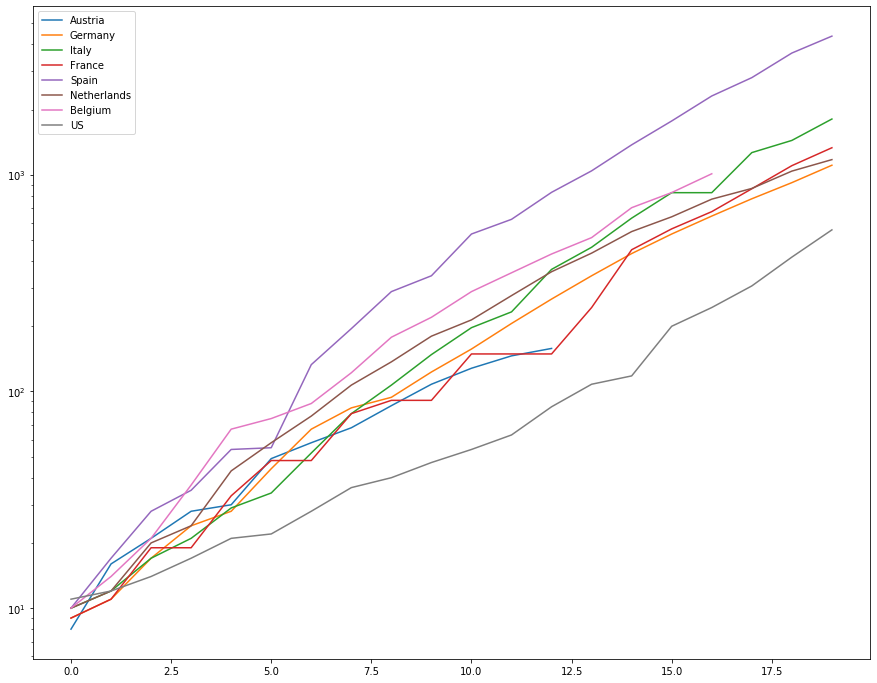

In [13]:
specialcountries = ['Austria','Germany', 'Italy', 'France', 'Spain', 'Netherlands', 'Belgium','US']


dthr   = 10
maxlen = 20

dt  = {}
dts = {}
for country in specialcountries:
    dtraj = np.array(jhudata.CountryData(country)['Deaths'])
    dtraj_start = np.argmin((dtraj - dthr)**2)
    dtraj = dtraj[dtraj_start:min(len(dtraj),dtraj_start + maxlen)]
    
    dt[country] = dtraj
    dts[country] = dtraj_start
    
    plt.plot(dt[country], label = country)
    

for i,c1 in enumerate(specialcountries):
    for c2 in specialcountries[i+1:]:
        print(c1,c2)

plt.yscale('log')
plt.legend()
plt.show()

Austria
Germany
Italy
France
Spain


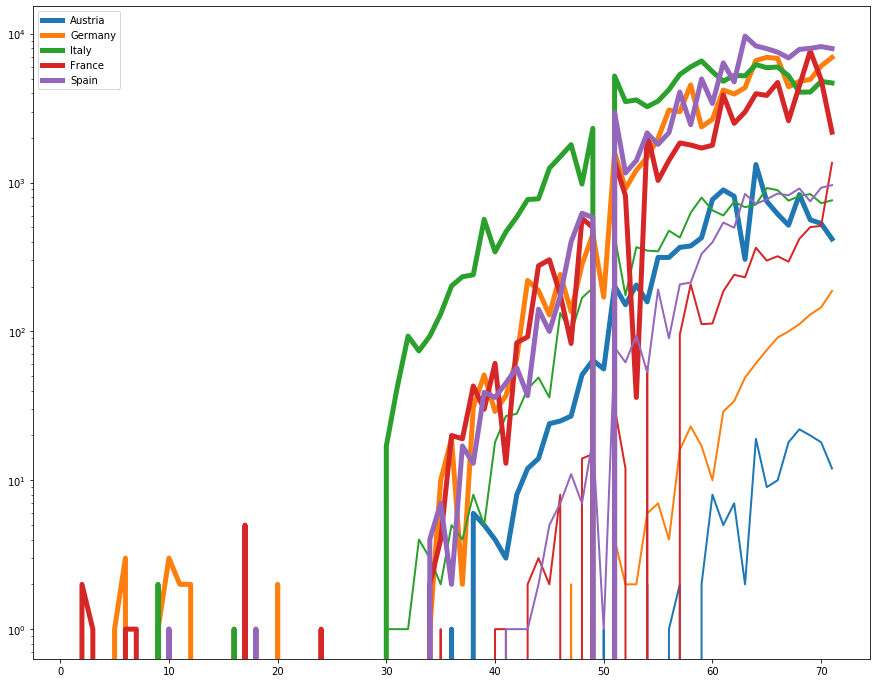

In [14]:
specialcountries = ['Austria','Germany', 'Italy', 'France', 'Spain']


for i,country in enumerate(specialcountries):
    print(country)
    plt.plot(jhudata.CountryData(country)['Confirmed'] - jhudata.CountryData(country)['Confirmed'].shift(), c = colornames[i], lw = 5, label = country)
    plt.plot(jhudata.CountryData(country)['Deaths']    - jhudata.CountryData(country)['Deaths'].shift(),    c = colornames[i], lw = 2)
plt.legend()
plt.yscale('log')
plt.show()

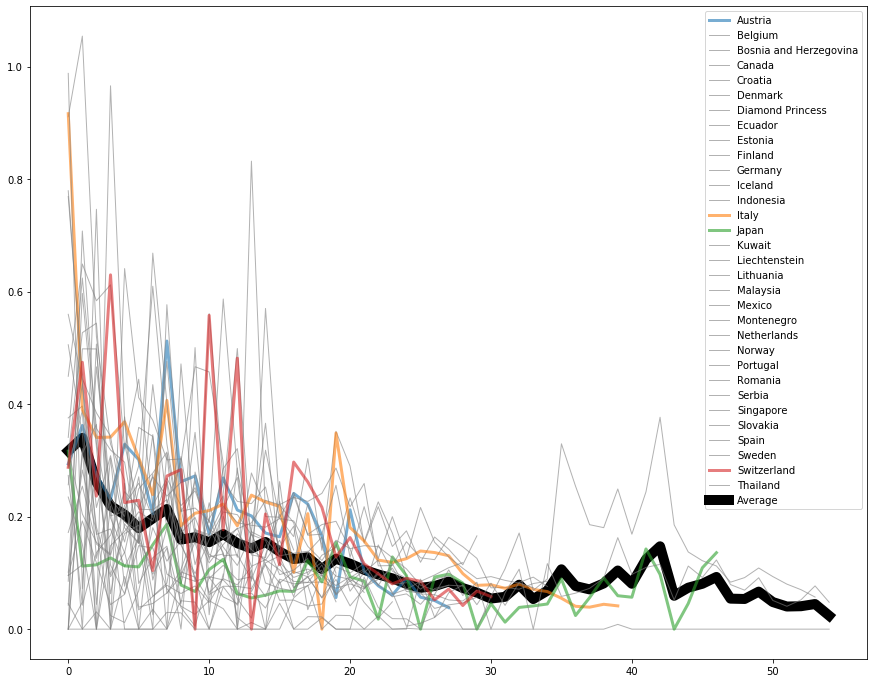

In [35]:
countrylist = ['Austria', 'Belgium', 'Bosnia and Herzegovina', 'Canada', 'Croatia', 'Denmark', 'Diamond Princess', 'Ecuador', 'Estonia', 'Finland', 'Germany', 'Iceland', 'Indonesia', 'Italy', 'Japan', 'Kuwait', 'Liechtenstein', 'Lithuania', 'Malaysia', 'Mexico', 'Montenegro', 'Netherlands', 'Norway', 'Portugal', 'Romania', 'Serbia', 'Singapore', 'Slovakia', 'Spain', 'Sweden', 'Switzerland', 'Thailand']
thres_cases = 30

dlc_sum   = np.zeros(0)
dlc_count = np.zeros(0)

def addgrowth(dlc,dlc_sum,dlc_count):
    if len(dlc) > len(dlc_sum):
        dlc_sum   = np.concatenate([dlc_sum,   np.zeros(len(dlc)-len(dlc_sum))])
        dlc_count = np.concatenate([dlc_count, np.zeros(len(dlc)-len(dlc_count))])
    dlc_sum[:len(dlc)] += dlc
    dlc_count[:len(dlc)] += np.ones(len(dlc))
    return dlc_sum,dlc_count
        
specialcountries = ['Austria','Italy', 'Switzerland','Japan']
i = 0
for country in countrylist:
    confc  = jhudata.CountryData(country)['Confirmed']
    confc  = confc[confc >= thres_cases]
    dlc    = np.diff(np.log(confc))
    dlc_sum,dlc_count = addgrowth(dlc,dlc_sum,dlc_count)
    c      = 'gray'
    lw     = 1
    if country in specialcountries:
        c  = colornames[i % len(colornames)]
        lw = 3
        i +=1
    plt.plot(dlc,label = country, c = c, lw = lw,alpha = 0.6, zorder = 100)

plt.plot(dlc_sum/dlc_count, label = 'Average', c = 'black', lw = 10, zorder = 10)
plt.legend()
plt.show()